In [41]:
!pip install sklearn numpy pandas plotly umap-learn kagglehub tqdm transformers

# If you want GPU support install pytorch according to their guide:
# https://pytorch.org/get-started/locally/

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [15 lines of output]
  The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
  rather than 'sklearn' for pip commands.
  
  Here is how to fix this error in the main use cases:
  - use 'pip install scikit-learn' rather than 'pip install sklearn'
  - replace 'sklearn' by 'scikit-learn' in your pip requirements files
    (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
  - if the 'sklearn' package is used by one of your dependencies,
    it would be great if you take some time to track which package uses
    'sklearn' instead of 'scikit-learn' and report it to their issue tracker
  - as a last resort, set the environment variable
    SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
  
  More information is available at
  https://github.com/scikit-learn/sklearn-pypi-package
  [end of output]
  
  note: This error originates from a subpr

In [1]:
from pathlib import Path

import kagglehub
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
import torch
from PIL import Image
from numpy.typing import NDArray
from sklearn import cluster
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
from transformers import AutoFeatureExtractor, AutoModel
from umap import UMAP
from sklearn.metrics.cluster import adjusted_rand_score

In [2]:
def project_vectors(data: NDArray, technique: str = "tsne", **options) -> NDArray:
    if technique == "pca":
        transformer = PCA(**options)
    elif technique == "tsne":
        transformer = TSNE(**options)
    elif technique == "umap":
        transformer = UMAP(**options)
    else:
        raise ValueError(
            f"Invalid technique: {technique}. Choose from 'pca', 'tsne', or 'umap'."
        )

    transformed_data = transformer.fit_transform(data)
    return transformed_data


def estimate_dbscan_eps(embeddings: NDArray, n_samples: int = 1000, k: int = 5, quantile: float = 0.1) -> float:
    """
    Estimates a suitable eps parameter for DBSCAN based on k-distance graph.
    
    Parameters:
    -----------
    embeddings : numpy.ndarray
        The embeddings to analyze, shape (n_samples, n_features)
    n_samples : int
        Number of samples to use for estimation (to speed up computation)
    k : int
        Number of neighbors to consider
    quantile : float
        Quantile to use for selecting the eps value (lower means tighter clusters)
    plot : bool
        Whether to generate and display a k-distance plot
        
    Returns:
    --------
    eps : float
        Estimated eps value for DBSCAN
    """
    if embeddings.shape[0] > n_samples:
        indices = np.random.choice(embeddings.shape[0], n_samples, replace=False)
        sample_data = embeddings[indices]
    else:
        sample_data = embeddings

    nbrs = NearestNeighbors(n_neighbors=k + 1).fit(sample_data)
    distances, _ = nbrs.kneighbors(sample_data)

    kdistances = np.sort(distances[:, k])

    eps = np.quantile(kdistances, quantile)

    print(f"Estimated eps value: {eps}")
    return eps

In [3]:
pio.renderers.default = "browser"
print(torch.cuda.is_available())

True


In [4]:
path = kagglehub.dataset_download("prasunroy/natural-images")
path = Path(path)
print("Path to dataset files:", path)

Path to dataset files: C:\Users\miknowak\.cache\kagglehub\datasets\prasunroy\natural-images\versions\1


In [5]:
paths_to_images = list(path.glob("**/*.jpg"))
print("Number of images:", len(paths_to_images))
assert len(paths_to_images) > 0, "No images found in the dataset."

Number of images: 13798


In [6]:
path_df = pd.DataFrame(paths_to_images, columns=["path"])
path_df['class'] = path_df['path'].apply(lambda x: x.parent.name)
path_df['class'] = path_df['class'].astype("category")
path_df = path_df.sample(n=600).reset_index(drop=True)
path_df

,path,class
0,C:\Users\miknowak\.cache\kagglehub\datasets\prasu...,car
1,C:\Users\miknowak\.cache\kagglehub\datasets\prasu...,motorbike
2,C:\Users\miknowak\.cache\kagglehub\datasets\prasu...,fruit
3,C:\Users\miknowak\.cache\kagglehub\datasets\prasu...,fruit
4,C:\Users\miknowak\.cache\kagglehub\datasets\prasu...,dog
...,...,...
595,C:\Users\miknowak\.cache\kagglehub\datasets\prasu...,car
596,C:\Users\miknowak\.cache\kagglehub\datasets\prasu...,person
597,C:\Users\miknowak\.cache\kagglehub\datasets\prasu...,cat
598,C:\Users\miknowak\.cache\kagglehub\datasets\prasu...,motorbike


In [22]:
def generate_image_embeddings(
        image_paths: list[str | Path],
        model_name: str = "microsoft/resnet-50",
        batch_size: int = 8
) -> np.ndarray:
    """
    Generate embeddings for a batch of images using a pretrained model from HuggingFace with CUDA support.

    Args:
        image_paths (List[str | Path]): List of image file paths
        model_name (str): Name of the pretrained model to use. Default is "microsoft/resnet-50"
        batch_size (int): Number of images to process per batch. Default is 8

    Returns:
        np.ndarray: 2D array of image embedding vectors (num_images, embedding_dim)
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name).to(device)

    all_embeddings = []

    for i in tqdm(range(0, len(image_paths), batch_size)):
        batch_paths = image_paths[i:i + batch_size]
        images = [Image.open(path).convert("RGB") for path in batch_paths]

        inputs = feature_extractor(images=images, return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = model(**inputs)

        if hasattr(outputs, 'pooler_output'):
            embeddings = outputs.pooler_output.cpu().numpy()
        else:
            embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()

        all_embeddings.append(embeddings)

    return np.vstack(all_embeddings).squeeze()

In [23]:
embeddings = generate_image_embeddings(path_df.path.tolist(), batch_size=16)

Using device: cuda


In [24]:
def plot_embeddings(embeddings: NDArray,
                    clustering_results: NDArray,
                    symbol: str = "class",
                    color: str = "clustering_results",

                    classes: list[str] = path_df["class"],
                    paths: list[str] = path_df["path"],
                    plot_3d: bool = False):
    reduction_techniques = "tsne"
    if embeddings.shape[1] > 2:
        reduced_embeddings = project_vectors(embeddings, technique=reduction_techniques,
                                             n_components=3 if plot_3d else 2, random_state=6)
        print(f"Reduced embeddings from {embeddings.shape[1]} to {reduced_embeddings.shape[1]}")
    else:
        reduced_embeddings = embeddings
    df = pd.DataFrame({
        "x": reduced_embeddings[:, 0],
        "y": reduced_embeddings[:, 1],
        "class": classes,
        "path": list(map(str, paths)),
        "clustering_results": clustering_results
    })

    if plot_3d:
        df["z"] = reduced_embeddings[:, 2]

    df = df.astype({
        "class": "category",
        "clustering_results": "category"
    })
    if plot_3d:
        fig = px.scatter_3d(df, x="x", y="y", z="z", color=color, symbol=symbol,
                            title=f"{reduction_techniques} reduction technique. Visualization of Image Embeddings",
                            hover_data=["path"])
    else:
        fig = px.scatter(df, x="x", y="y", color=color, symbol=symbol,
                         title=f"{reduction_techniques} reduction technique. Visualization of Image Embeddings",
                         hover_data=["path"])

    fig.update_traces(textfont_size=25, marker=dict(size=25))
    fig.update_layout(template="plotly")
    fig.show()


plot_embeddings(embeddings, 0, symbol="class", color="class")

Reduced embeddings from 2048 to 2


In [25]:
path_with_search_string = path_df[path_df.path.apply(lambda x: str(x)).str.contains("cat_0218.jpg")].path.values[0]
path_with_search_string

WindowsPath('C:/Users/miknowak/.cache/kagglehub/datasets/prasunroy/natural-images/versions/1/natural_images/cat/cat_0218.jpg')

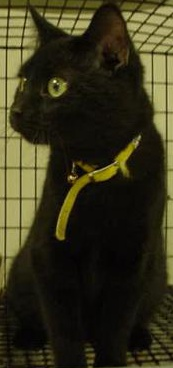

In [26]:
Image.open(path_with_search_string)

In [27]:
def cluster_embeddings(embeddings: NDArray, algorithm_name: str = 'KMeans', **kwargs):
    """
    Clusters embeddings using a specified clustering algorithm from sklearn.
    
    Parameters:
    -----------
    embeddings : numpy.ndarray
        The embeddings to cluster, shape (n_samples, n_features)
    algorithm_name : str
        Name of the clustering algorithm to use (must be available in sklearn.cluster
        or be GaussianMixture)
    **kwargs : 
        Additional parameters to pass to the clustering algorithm
        
    Returns:
    --------
    labels : numpy.ndarray
        Cluster labels for each embedding, shape (n_samples,)
    model : object
        The fitted clustering model
    """
    if not isinstance(embeddings, np.ndarray):
        raise TypeError("Embeddings must be a numpy array")

    if len(embeddings.shape) != 2:
        raise ValueError(f"Embeddings must be 2D array, got shape {embeddings.shape}")

    if algorithm_name == 'GaussianMixture':
        algorithm_class = GaussianMixture
    else:
        try:
            algorithm_class = getattr(cluster, algorithm_name)
        except AttributeError:
            raise ValueError(f"Algorithm '{algorithm_name}' not found in sklearn.cluster or is not GaussianMixture")

    model = algorithm_class(**kwargs)

    if hasattr(model, 'fit_predict'):
        labels = model.fit_predict(embeddings)
    elif hasattr(model, 'fit') and hasattr(model, 'predict'):

        model.fit(embeddings)
        labels = model.predict(embeddings)
    else:
        raise ValueError(f"Algorithm '{algorithm_name}' does not support required methods")

    return labels, model


In [30]:
clustering_results, model1 = cluster_embeddings(embeddings, 'KMeans', n_clusters=7)
print(f"KMeans labels shape: {clustering_results.shape}, unique clusters: {np.unique(clustering_results)}")
plot_embeddings(embeddings,
                clustering_results,
                symbol="class",
                color="clustering_results",
                plot_3d=True
                )

KMeans labels shape: (600,), unique clusters: [0 1 2 3 4 5 6]
Reduced embeddings from 2048 to 3


In [17]:
adjusted_rand_score(clustering_results, path_df["class"].cat.codes)

0.8050666122758197

In [31]:
reduced_embeddings = project_vectors(embeddings,
                                     technique="pca",  # Why not TSNE? 
                                     n_components=2,
                                     random_state=6)

clustering_results, model1 = cluster_embeddings(reduced_embeddings, 'KMeans', n_clusters=8)
print(f"KMeans labels shape: {clustering_results.shape}, unique clusters: {np.unique(clustering_results)}")
plot_embeddings(reduced_embeddings,
                clustering_results,
                symbol="class",
                color="clustering_results")

KMeans labels shape: (600,), unique clusters: [0 1 2 3 4 5 6 7]


In [32]:
labels2, model2 = cluster_embeddings(embeddings, 'DBSCAN',
                                     eps=estimate_dbscan_eps(embeddings), min_samples=5)
print(f"DBSCAN labels shape: {labels2.shape}, unique clusters: {np.unique(labels2)}")

plot_embeddings(embeddings,
                labels2,
                symbol="class",
                color="clustering_results")

Estimated eps value: 3.1394101858139036
DBSCAN labels shape: (600,), unique clusters: [-1  0  1  2  3  4  5  6  7  8]
Reduced embeddings from 2048 to 2


In [45]:
# reduced_embeddings = project_vectors(embeddings,
#                                      technique="pca",  # Why not TSNE? 
#                                      n_components=2,
#                                      random_state=6)

labels2, model2 = cluster_embeddings(embeddings, 'DBSCAN',
                                     eps=estimate_dbscan_eps(embeddings), min_samples=5)
print(f"DBSCAN labels shape: {labels2.shape}, unique clusters: {np.unique(labels2)}")

plot_embeddings(embeddings,
                labels2,
                symbol="class",
                color="clustering_results")

Estimated eps value: 3.361341381072998
DBSCAN labels shape: (600,), unique clusters: [-1  0  1  2  3  4  5  6]
Reduced embeddings from 2048 to 2


In [33]:
labels3, model3 = cluster_embeddings(embeddings, 'GaussianMixture', n_components=8)
print(f"GaussianMixture labels shape: {labels3.shape}, unique clusters: {np.unique(labels3)}")

plot_embeddings(embeddings,
                labels3,
                symbol="class",
                color="clustering_results",
                # plot_3d=True
                )

GaussianMixture labels shape: (600,), unique clusters: [0 1 2 3 4 5 6 7]
Reduced embeddings from 2048 to 2


In [21]:
adjusted_rand_score(labels3, path_df["class"].cat.codes)

0.830083589357288

In [40]:
labels4, model4 = cluster_embeddings(embeddings, 'AgglomerativeClustering',
                                     n_clusters=8, linkage='ward')
print(f"AgglomerativeClustering labels shape: {labels4.shape}, unique clusters: {np.unique(labels4)}")
plot_embeddings(embeddings,
                labels4,
                symbol="class",
                color="clustering_results")

AgglomerativeClustering labels shape: (600,), unique clusters: [0 1 2 3 4 5 6 7]
Reduced embeddings from 2048 to 2


In [50]:
labels4

array([5, 5, 6, 5, 6, 4, 0, 7, 1, 6, 6, 5, 7, 2, 4, 2, 1, 7, 4, 5, 1, 6,
       7, 2, 7, 7, 0, 4, 5, 6, 6, 0, 1, 6, 7, 2, 2, 0, 7, 4, 3, 1, 6, 1,
       1, 2, 5, 3, 3, 7, 5, 0, 1, 4, 0, 7, 0, 0, 7, 4, 1, 6, 1, 4, 4, 2,
       1, 3, 0, 5, 2, 0, 4, 0, 0, 4, 0, 1, 0, 0, 2, 0, 2, 4, 0, 4, 1, 7,
       4, 4, 1, 1, 0, 3, 2, 0, 6, 5, 0, 6, 4, 3, 1, 4, 2, 5, 7, 5, 0, 2,
       5, 7, 5, 2, 5, 3, 2, 3, 1, 1, 0, 4, 3, 4, 4, 1, 0, 1, 6, 3, 3, 2,
       5, 1, 1, 5, 3, 4, 5, 2, 6, 3, 6, 4, 5, 5, 7, 5, 7, 2, 7, 7, 5, 6,
       4, 0, 7, 2, 7, 2, 0, 6, 3, 5, 2, 7, 5, 5, 3, 1, 3, 7, 2, 5, 4, 3,
       6, 4, 4, 6, 5, 1, 3, 0, 1, 1, 1, 1, 2, 4, 2, 6, 6, 5, 6, 7, 5, 1,
       7, 2, 3, 1, 2, 1, 1, 2, 0, 0, 3, 2, 6, 5, 0, 1, 4, 1, 2, 1, 2, 3,
       5, 5, 3, 7, 2, 4, 3, 5, 7, 5, 5, 6, 7, 3, 6, 1, 5, 3, 6, 7, 0, 3,
       5, 5, 4, 1, 3, 7, 6, 1, 7, 5, 5, 0, 6, 4, 4, 3, 7, 5, 5, 6, 0, 3,
       6, 7, 3, 6, 7, 4, 2, 4, 0, 0, 2, 1, 5, 0, 1, 4, 5, 2, 0, 5, 2, 7,
       3, 1, 0, 2, 2, 1, 7, 3, 3, 2, 1, 7, 7, 1, 6,

In [39]:
adjusted_rand_score(labels4, path_df["class"].cat.codes)

0.9900562114074025

In [52]:
adjusted_rand_score(labels3, labels4)

-0.0024246409872088733

In [37]:
adjusted_rand_score([1,1,0,0], [0,0 ,1,1])

1.0

In [35]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

def find_optimal_clusters(embeddings: NDArray, max_clusters: int =10, random_state=42):
    """
    Determine the optimal number of clusters for embedding data using multiple methods:
    1. Elbow Method (inertia)
    2. Silhouette Score
    3. Davies-Bouldin Index
    
    Parameters:
    -----------
    embeddings : numpy.ndarray
        The embedding vectors to cluster, shape (n_samples, n_features)
    max_clusters : int, optional (default=10)
        Maximum number of clusters to try
    random_state : int, optional (default=42)
        Random seed for KMeans
        
    Returns:
    --------
    fig : plotly.graph_objects.Figure
        A figure with subplots showing the evaluation metrics
    optimal_k : dict
        Dictionary with suggested optimal k values by different methods
    """
    # Ensure we have enough data points
    max_clusters = min(max_clusters, len(embeddings) - 1)
    
    # Initialize lists to store metrics
    range_n_clusters = list(range(2, max_clusters + 1))
    inertia_values = []
    silhouette_values = []
    davies_bouldin_values = []
    
    # Calculate metrics for each number of clusters
    for n_clusters in range_n_clusters:
        # Initialize and fit KMeans
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
        cluster_labels = kmeans.fit_predict(embeddings)
        
        # Calculate inertia (within-cluster sum of squares)
        inertia_values.append(kmeans.inertia_)
        
        # Calculate silhouette score (higher is better)
        if len(np.unique(cluster_labels)) > 1:  # Need at least 2 clusters with points
            silhouette_values.append(silhouette_score(embeddings, cluster_labels))
        else:
            silhouette_values.append(0)
        
        # Calculate Davies-Bouldin index (lower is better)
        davies_bouldin_values.append(davies_bouldin_score(embeddings, cluster_labels))
    
    # Find optimal clusters using different methods
    optimal_k = {}
    

    inertia_diffs = np.diff(inertia_values)
    inertia_diffs2 = np.diff(inertia_diffs)
    optimal_k['elbow'] = range_n_clusters[np.argmin(inertia_diffs2) + 1]
    
    # Silhouette method (maximize)
    optimal_k['silhouette'] = range_n_clusters[np.argmax(silhouette_values)]
    
    # Davies-Bouldin method (minimize)
    optimal_k['davies_bouldin'] = range_n_clusters[np.argmin(davies_bouldin_values)]
    
    # Create subplot figure
    fig = make_subplots(
        rows=3, cols=1,
        subplot_titles=(
            "Elbow Method (Inertia)",
            "Silhouette Score (higher is better)",
            "Davies-Bouldin Index (lower is better)"
        ),
        vertical_spacing=0.15
    )
    
    # Add traces for each metric
    # Elbow Method
    fig.add_trace(
        go.Scatter(
            x=range_n_clusters,
            y=inertia_values,
            mode='lines+markers',
            name='Inertia',
            line=dict(color='blue')
        ),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(
            x=[optimal_k['elbow']],
            y=[inertia_values[range_n_clusters.index(optimal_k['elbow'])] 
               if optimal_k['elbow'] in range_n_clusters else 0],
            mode='markers',
            marker=dict(color='red', size=12, symbol='star'),
            name='Optimal k (Elbow)'
        ),
        row=1, col=1
    )
    
    # Silhouette Score
    fig.add_trace(
        go.Scatter(
            x=range_n_clusters,
            y=silhouette_values,
            mode='lines+markers',
            name='Silhouette Score',
            line=dict(color='green')
        ),
        row=2, col=1
    )
    fig.add_trace(
        go.Scatter(
            x=[optimal_k['silhouette']],
            y=[silhouette_values[range_n_clusters.index(optimal_k['silhouette'])]],
            mode='markers',
            marker=dict(color='red', size=12, symbol='star'),
            name='Optimal k (Silhouette)'
        ),
        row=2, col=1
    )
    
    # Davies-Bouldin Index
    fig.add_trace(
        go.Scatter(
            x=range_n_clusters,
            y=davies_bouldin_values,
            mode='lines+markers',
            name='Davies-Bouldin Index',
            line=dict(color='purple')
        ),
        row=3, col=1
    )
    fig.add_trace(
        go.Scatter(
            x=[optimal_k['davies_bouldin']],
            y=[davies_bouldin_values[range_n_clusters.index(optimal_k['davies_bouldin'])]],
            mode='markers',
            marker=dict(color='red', size=12, symbol='star'),
            name='Optimal k (Davies-Bouldin)'
        ),
        row=3, col=1
    )
    
    # Update layout
    fig.update_layout(
        title='Optimal Number of Clusters Evaluation',
        height=800,
        width=900,
        showlegend=True,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=-0.2,
            xanchor="center",
            x=0.5
        )
    )
    
    # Update x-axis labels
    fig.update_xaxes(title_text="Number of Clusters")
    
    # Update y-axis labels
    fig.update_yaxes(title_text="Inertia", row=1, col=1)
    fig.update_yaxes(title_text="Silhouette Score", row=2, col=1)
    fig.update_yaxes(title_text="Davies-Bouldin Index", row=3, col=1)
    
    return fig, optimal_k
fig, optimal_k = find_optimal_clusters(embeddings, max_clusters=10)
fig.show()

Theoretical Explanation of Clustering Evaluation Methods
1. Elbow Method (Inertia)
Theoretical Explanation:
The Elbow Method tracks the sum of squared distances between each point and its assigned cluster center (inertia). As we increase the number of clusters, inertia naturally decreases because points are closer to their centers. The "elbow" represents the point of diminishing returns, where adding more clusters doesn't significantly reduce the inertia. This inflection point occurs because we've captured the natural structure of the data, and additional clusters start separating points that should belong together.
Simple Summary:
The Elbow Method identifies where adding more clusters stops providing significant benefit. It finds the point where the inertia curve bends like an elbow.
2. Silhouette Score
Theoretical Explanation:
The Silhouette Score measures how similar points are to their assigned cluster compared to other clusters. For each point, it calculates (b-a)/max(a,b), where 'a' is the mean distance to points in the same cluster and 'b' is the mean distance to points in the nearest different cluster. The score ranges from -1 to 1, with higher values indicating better-defined clusters. A high silhouette score means data points are well-matched to their own clusters and poorly matched to neighboring clusters.
Simple Summary:
Silhouette Score measures how well-separated clusters are from each other. Higher scores indicate better-defined, more distinct clusters.
3. Davies-Bouldin Index
Theoretical Explanation:
The Davies-Bouldin Index evaluates clustering quality based on the ratio of within-cluster scatter to between-cluster separation. For each cluster, it computes the ratio of the sum of within-cluster distances to the distance between cluster centers, then averages these ratios. This metric focuses on both cluster compactness (points close to their centers) and separation (clusters far from each other). Lower values indicate better clustering, with compact, well-separated clusters.
Simple Summary:
Davies-Bouldin Index measures the average similarity between clusters, with lower values indicating better separation. It seeks compact clusters that are far apart from each other.

For each data point i, the silhouette coefficient s(i) is calculated using:
s(i) = (b(i) - a(i)) / max(a(i), b(i))
Where:

a(i) is the average distance between point i and all other points in the same cluster (cohesion)
b(i) is the average distance between point i and all points in the nearest neighboring cluster (separation)

In [ ]:
[0, 0, 1, 1]                          [1, 1, 0, 0]